In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# rolling minmax scaling 함수 (window=24)
def rolling_minmax_scale(series, window=24):
    roll_min = series.rolling(window=window, min_periods=window).min()
    roll_max = series.rolling(window=window, min_periods=window).max()
    scaled = (series - roll_min) / ((roll_max - roll_min) + 1e-8)
    scaled = scaled.replace([np.inf, -np.inf], np.nan)
    scaled = scaled.fillna(1.0)
    return scaled.clip(upper=1.0)

# binning 및 one-hot 인코딩 함수 (결과를 정수 0,1로)
def bin_and_encode(data, features, bins=100, drop_original=True):
    for feature in features:
        data[f'{feature}_Bin'] = pd.cut(data[feature], bins=bins, labels=False)
        one_hot = pd.get_dummies(data[f'{feature}_Bin'], prefix=f'{feature}_Bin').astype(np.int32)
        expected_columns = [f'{feature}_Bin_{i}' for i in range(bins)]
        one_hot = one_hot.reindex(columns=expected_columns, fill_value=0)
        data = pd.concat([data, one_hot], axis=1)
        if drop_original:
            data.drop(columns=[f'{feature}_Bin'], inplace=True)
    numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        data[col] = data[col].astype('float32')
    return data

# TimeSeriesDataset (분류용): lookback 후, 바로 다음 봉의 close 값을 이전 봉과 비교하여 상승이면 1, 하락이면 0을 타깃으로 함
class TimeSeriesDataset(Dataset):
    def __init__(self, input_data, target_data, lookback=24):
        self.input_data = input_data.values
        self.target_data = target_data.values
        self.lookback = lookback

    def __len__(self):
        return len(self.input_data) - self.lookback

    def __getitem__(self, idx):
        x = self.input_data[idx: idx + self.lookback, :]
        # 타깃: lookback 후의 close 값과 바로 전 봉(close 값) 비교
        y = self.target_data[idx + self.lookback, 0]
        y_prev = self.target_data[idx + self.lookback - 1, 0]
        y_target = 1 if y > y_prev else 0
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y_target, dtype=torch.long)

# 분류 모델 정의 (상승/하락 예측)
class EncoderOnlyTransformerCustom(nn.Module):
    def __init__(self, input_dim, embedding_dim=512, num_layers=6, nhead=8, 
                 ffn_dim=2048, num_classes=2, max_seq_len=24):
        super(EncoderOnlyTransformerCustom, self).__init__()
        self.token_embedding = nn.Linear(input_dim, embedding_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=nhead, dim_feedforward=ffn_dim)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, num_classes)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        x = self.token_embedding(x)
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, seq_len)
        pos_emb = self.position_embedding(positions)
        x = x + pos_emb
        x = x.transpose(0, 1)  # Transformer의 입력형태: [seq_len, batch, features]
        x = self.transformer_encoder(x)
        return self.fc(x[-1, :, :])  # 마지막 타임스탭 출력

# 평가 함수 (분류용)
def evaluate_model(model, data_loader, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    criterion = nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item()
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
    return total_loss / len(data_loader), correct / total

# =============================
# 백테스팅 코드 시작
# =============================

# 1. 데이터 로드 및 전처리 (파일명 및 경로에 맞게 수정)
data = pd.read_csv("ETH_upbit_KRW_min5.csv", index_col=0)
data = data[['open', 'high', 'low', 'close']]
data.index = pd.to_datetime(data.index)

# 각 OHLC 열에 대해 rolling minmax scaling (window=24)
ohlc_features = ['open', 'high', 'low', 'close']
for feature in ohlc_features:
    data[feature] = rolling_minmax_scale(data[feature], window=24)

# one-hot 인코딩: OHLC 열은 100 구간으로 나눔
data_encoded = bin_and_encode(data.copy(), ohlc_features, bins=100, drop_original=True)

# 타깃은 원본 close 값을 사용 (상승/하락 판단용)
data['close_target'] = data['close']
data = data.dropna()

final_input_columns = [col for col in data_encoded.columns if '_Bin_' in col]
final_target_column = ['close_target']

data_input = data_encoded[final_input_columns]
data_target = data[final_target_column]

# 2. 백테스팅 데이터셋 구성 (전체 데이터 대상으로 사용)
lookback = 24
backtest_dataset = TimeSeriesDataset(data_input, data_target, lookback=lookback)
backtest_loader = DataLoader(backtest_dataset, batch_size=32, shuffle=False)

# 3. 모델 로드 (학습 시 저장한 파라미터 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = data_input.shape[1]
model = EncoderOnlyTransformerCustom(
    input_dim=input_dim, 
    embedding_dim=512, 
    num_layers=6, 
    nhead=8,
    ffn_dim=2048, 
    num_classes=2, 
    max_seq_len=lookback
).to(device)

# 파라미터 파일 이름(예: model_experiment_15.pth)이 분류용으로 학습된 파라미터여야 함
model.load_state_dict(torch.load("model_experiment_15.pth", map_location=device))
model.eval()

# 4. 백테스팅 수행: 전체 데이터에 대해 상승/하락 예측 정확도 계산
loss, accuracy = evaluate_model(model, backtest_loader, device)
print(f"Backtest Accuracy: {accuracy*100:.2f}%")


c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\User\anaconda3\envs\py39coin\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Backtest Accuracy: 54.67%


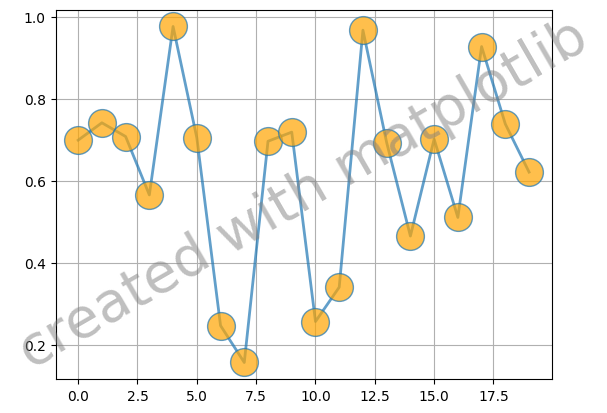

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)


fig, ax = plt.subplots()
ax.plot(np.random.rand(20), '-o', ms=20, lw=2, alpha=0.7, mfc='orange')
ax.grid()

ax.text(0.5, 0.5, 'created with matplotlib', transform=ax.transAxes,
        fontsize=40, color='gray', alpha=0.5,
        ha='center', va='center', rotation=30)

plt.show()

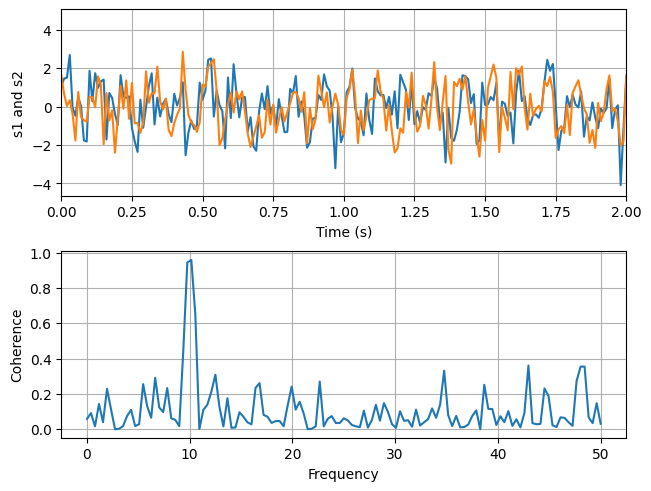

In [2]:

import matplotlib.pyplot as plt
import numpy as np

# Fixing random state for reproducibility
np.random.seed(19680801)

dt = 0.01
t = np.arange(0, 30, dt)
nse1 = np.random.randn(len(t))                 # white noise 1
nse2 = np.random.randn(len(t))                 # white noise 2

# Two signals with a coherent part at 10 Hz and a random part
s1 = np.sin(2 * np.pi * 10 * t) + nse1
s2 = np.sin(2 * np.pi * 10 * t) + nse2

fig, axs = plt.subplots(2, 1, layout='constrained')
axs[0].plot(t, s1, t, s2)
axs[0].set_xlim(0, 2)
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('s1 and s2')
axs[0].grid(True)

cxy, f = axs[1].cohere(s1, s2, NFFT=256, Fs=1. / dt)
axs[1].set_ylabel('Coherence')

plt.show()